## Lesson 17 - Statistics Packages

In this lesson we'll consider some of the various statistics tools available in Python. Many packages provide statistical support: Pandas, Numpy, Scipy, and Scikit-bio.

You will probably have to install `scikit-bio` and `outlier_utils` before proceeding:

```
conda install -c https://conda.anaconda.org/biocore scikit-bio
pip install outlier_utils
```

In [1]:
# import required packages
import pandas as pd
import numpy as np
import scipy
import skbio # this is scikit-bio
import matplotlib.pyplot as plt
import seaborn as sns
from outliers import smirnov_grubbs as grubbs
%matplotlib inline

In [2]:
# set up pandas and seaborn environments
pd.set_option('display.max_rows', 25)
sns.set()
sns.set_context('notebook')
sns.set_palette('colorblind')

### Basic statistics

#### Basic stats with Pandas

A large number of methods for computing descriptive statistics and other related operations on Series, DataFrame, and Panel. Most of these are aggregations (hence producing a lower-dimensional result) like `sum()`, `mean()`, and `quantile()`, but some of them, like `cumsum()` and `cumprod()`, produce an object of the same size. Generally speaking, these methods take an axis argument, just like `ndarray.{sum, std, ...}`, but the axis can be specified by name or integer:

* Series: no axis argument needed
* DataFrame: “index” (axis=0, default), “columns” (axis=1)
* Panel: “items” (axis=0), “major” (axis=1, default), “minor” (axis=2)

Function | Description
--------- | ----------
count | Number of non-null observations
sum | Sum of values
mean | Mean of values
mad | Mean absolute deviation
median | Arithmetic median of values
min | Minimum
max | Maximum
mode | Mode
abs | Absolute Value
prod | Product of values
std | Bessel-corrected sample standard deviation
var | Unbiased variance
sem | Standard error of the mean
skew | Sample skewness (3rd moment)
kurt | Sample kurtosis (4th moment)
quantile | Sample quantile (value at %)
cumsum | Cumulative sum
cumprod | Cumulative product
cummax | Cumulative maximum
cummin | Cumulative minimum

#### Example: Monthly precipitation in La Jolla from 2008 to 2016

In [3]:
# format the data: covert to datetime, average precipitation per month, get month and year, reset index
df = pd.read_csv('../data/la_jolla_precip_monthly.csv')
df['DATE'] = pd.to_datetime(df['DATE'])
df = df.groupby('DATE').mean()
df['MONTH'] = [x.month for x in df.index]
df['YEAR'] = [x.year for x in df.index]
df.reset_index(inplace=True)

In [4]:
# examine the resulting dataframe
df.head()

,DATE,LATITUDE,LONGITUDE,ELEVATION,PRCP,MONTH,YEAR
0,2008-12-01,32.82540,-117.2397,154.80,112.40,12,2008
1,2009-01-01,32.82540,-117.2397,154.80,6.90,1,2009
2,2009-02-01,32.82540,-117.2397,154.80,72.60,2,2009
3,2009-03-01,32.82555,-117.2449,152.25,6.10,3,2009
4,2009-04-01,32.82555,-117.2449,152.25,2.05,4,2009


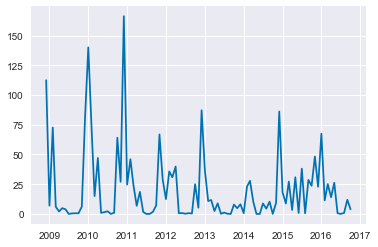

In [5]:
# explore the data using a plot
plt.plot(df.DATE, df.PRCP);

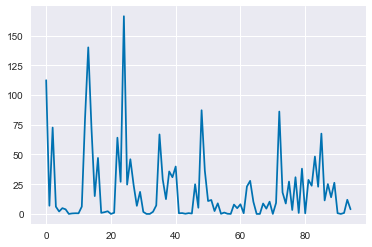

In [6]:
# make sure our index is sequential
plt.plot(df.index, df.PRCP);

In [7]:
# describe
df.describe()

,LATITUDE,LONGITUDE,ELEVATION,PRCP,MONTH,YEAR
count,95.000000,95.000000,95.000000,95.000000,95.000000,95.000000
mean,32.830764,-117.245553,147.555789,20.878070,6.452632,2012.378947
std,0.007165,0.001824,6.192505,30.779847,3.457242,2.302538
min,32.825400,-117.250100,139.200000,0.000000,1.000000,2008.000000
25%,32.825550,-117.245833,139.200000,0.850000,3.500000,2010.000000
50%,32.825550,-117.244900,152.250000,8.750000,6.000000,2012.000000
75%,32.840533,-117.244900,152.250000,27.116667,9.000000,2014.000000
max,32.840533,-117.239700,154.800000,166.200000,12.000000,2016.000000


In [8]:
# mean
df.PRCP.mean()

20.878070175438598

In [9]:
# std
df.PRCP.std()

30.779846675482016

In [10]:
# quantile
df.PRCP.quantile(0.25), df.PRCP.quantile(0.5), df.PRCP.quantile(0.75)

(0.8500000000000001, 8.75, 27.116666666666667)

In [11]:
# min
df.PRCP.min(), df.PRCP.idxmin()

(0.0, 7)

In [12]:
# max (with rounding)
df.PRCP.max(), df.PRCP.max().round(), df.PRCP.idxmax()

(166.19999999999999, 166.0, 24)

In [13]:
# cumsum
df.PRCP.cumsum()

0      112.400000
1      119.300000
2      191.900000
3      198.000000
4      200.050000
5      204.900000
6      208.750000
7      208.750000
8      209.150000
9      209.700000
10     210.200000
11     216.333333
         ...     
83    1799.216667
84    1822.066667
85    1889.566667
86    1900.916667
87    1926.016667
88    1940.016667
89    1966.216667
90    1966.816667
91    1966.816667
92    1967.616667
93    1979.516667
94    1983.416667
Name: PRCP, Length: 95, dtype: float64

In [14]:
# value_counts
df.PRCP.round().value_counts()

0.0      16
1.0      12
2.0       5
9.0       4
7.0       3
25.0      3
5.0       3
4.0       3
12.0      3
11.0      2
24.0      2
29.0      2
         ..
14.0      1
67.0      1
40.0      1
87.0      1
28.0      1
86.0      1
18.0      1
3.0       1
38.0      1
48.0      1
68.0      1
112.0     1
Name: PRCP, Length: 42, dtype: int64

### Regression analysis

#### Regression with Seaborn

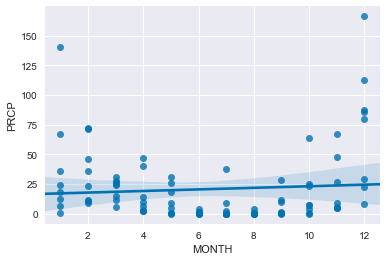

In [15]:
sns.regplot(x='MONTH', y='PRCP', data=df, order=1)

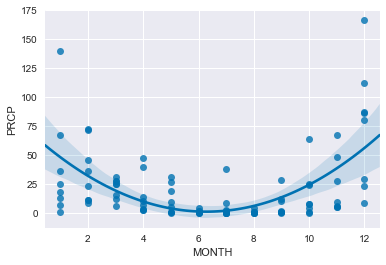

In [16]:
sns.regplot(x='MONTH', y='PRCP', data=df, order=2)

Seaborn is handy to generate plots, but it doesn't provide easy access to the coefficients. For more control, we can use Numpy, Scipy, and other statistics packages.

#### Regression with Numpy

##### np.polyfit - least squares polynomial fit (1st order)

In [17]:
# 1st order with np.polyfit
m, b = np.polyfit(df.MONTH, df.PRCP, 1)

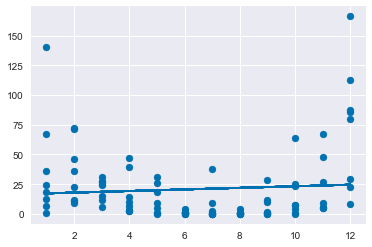

In [18]:
# plot scatter and polyfit
plt.scatter(df.MONTH, df.PRCP)
plt.plot(df.MONTH, m*df.MONTH + b, '-');

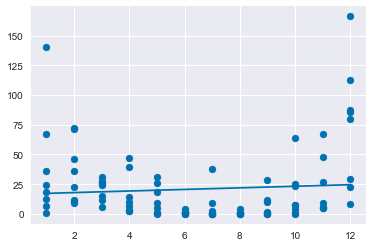

In [19]:
# sort DataFrame by month, then re-plot
df.sort_values('MONTH', inplace=True)
plt.scatter(df.MONTH, df.PRCP)
plt.plot(df.MONTH, m*df.MONTH + b, '-');

##### np.polyfit - least squares polynomial fit (2nd order)

In [20]:
# 2nd order with np.polyfit
p = np.polyfit(df.MONTH, df.PRCP, 2)

In [21]:
# values of p are in decending orders
p

array([  1.68178223, -21.14169112,  67.38422486])

In [22]:
# create a finely spaced array
x1 = np.linspace(1,12)
x1

array([  1.        ,   1.2244898 ,   1.44897959,   1.67346939,
         1.89795918,   2.12244898,   2.34693878,   2.57142857,
         2.79591837,   3.02040816,   3.24489796,   3.46938776,
         3.69387755,   3.91836735,   4.14285714,   4.36734694,
         4.59183673,   4.81632653,   5.04081633,   5.26530612,
         5.48979592,   5.71428571,   5.93877551,   6.16326531,
         6.3877551 ,   6.6122449 ,   6.83673469,   7.06122449,
         7.28571429,   7.51020408,   7.73469388,   7.95918367,
         8.18367347,   8.40816327,   8.63265306,   8.85714286,
         9.08163265,   9.30612245,   9.53061224,   9.75510204,
         9.97959184,  10.20408163,  10.42857143,  10.65306122,
        10.87755102,  11.10204082,  11.32653061,  11.55102041,
        11.7755102 ,  12.        ])

In [23]:
# calculate the y vector for the fit curve 
y1 = np.polyval(p, x1)
y1

array([ 47.92431598,  44.01806249,  40.28131809,  36.71408276,
        33.31635652,  30.08813935,  27.02943126,  24.14023226,
        21.42054233,  18.87036149,  16.48968972,  14.27852703,
        12.23687342,  10.36472889,   8.66209345,   7.12896708,
         5.76534979,   4.57124158,   3.54664245,   2.6915524 ,
         2.00597143,   1.48989954,   1.14333673,   0.966283  ,
         0.95873835,   1.12070278,   1.45217628,   1.95315887,
         2.62365054,   3.46365129,   4.47316111,   5.65218002,
         7.00070801,   8.51874507,  10.20629122,  12.06334644,
        14.08991075,  16.28598413,  18.6515666 ,  21.18665814,
        23.89125877,  26.76536847,  29.80898725,  33.02211512,
        36.40475206,  39.95689808,  43.67855318,  47.56971737,
        51.63039063,  55.86057297])

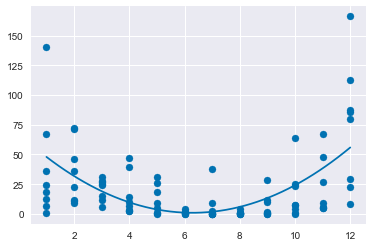

In [24]:
plt.scatter(df.MONTH, df.PRCP)
plt.plot(x1, y1, '-');

In [25]:
# 3rd order with np.polyfit
p = np.polyfit(df.MONTH, df.PRCP, 3)

In [26]:
y1 = np.polyval(p, x1)

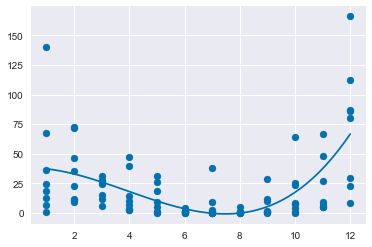

In [27]:
plt.scatter(df.MONTH, df.PRCP)
plt.plot(x1, y1, '-');

#### Fitting time series to a sinusoidal wave

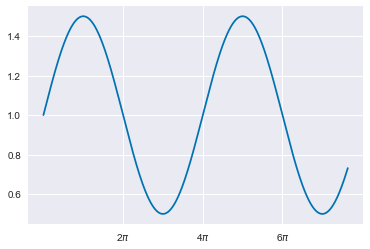

In [28]:
# sine wave refresher
period = 4*np.pi
freq = (2*np.pi)/period
phase = 0
amplitude = .5
offset = 1
x1 = np.linspace(0, 24, num=2000)
y1 = np.sin(x1 * freq + phase) * amplitude + offset

fig, ax = plt.subplots()
ax.plot(x1, y1)
ax.set_xticks([2*np.pi, 4*np.pi, 6*np.pi])
ax.set_xticklabels(['2$\pi$', '4$\pi$', '6$\pi$']);

In [29]:
# we are going to use the numerical index for our "t" variable
# make sure our index is sequential (December 2008 is zero)
df.sort_index(inplace=True)
df.head()

,DATE,LATITUDE,LONGITUDE,ELEVATION,PRCP,MONTH,YEAR
0,2008-12-01,32.82540,-117.2397,154.80,112.40,12,2008
1,2009-01-01,32.82540,-117.2397,154.80,6.90,1,2009
2,2009-02-01,32.82540,-117.2397,154.80,72.60,2,2009
3,2009-03-01,32.82555,-117.2449,152.25,6.10,3,2009
4,2009-04-01,32.82555,-117.2449,152.25,2.05,4,2009


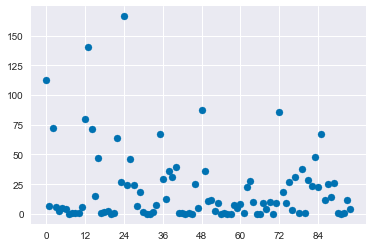

In [30]:
plt.scatter(df.index, df.PRCP)
plt.xticks(np.arange(0, df.index.max(), 12));

In [31]:
# store our values as new variables
t = df.index
data = df.PRCP

In [32]:
# guess the sine wave properties
guess_period = 12
guess_freq = (2*np.pi)/guess_period
guess_phase = 0
guess_amplitude = 10
guess_offset = 10

p0 = [guess_freq, guess_amplitude, guess_phase, guess_offset]

In [33]:
# create the function we want to fit
def my_sin(x, freq, amplitude, phase, offset):
    return np.sin(x * freq + phase) * amplitude + offset

In [34]:
# now do the fit
fit = scipy.optimize.curve_fit(my_sin, t, data, p0=p0)

In [35]:
# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = my_sin(t, *p0)

In [36]:
# recreate the fitted curve using the optimized parameters
data_fit = my_sin(t, *fit[0])

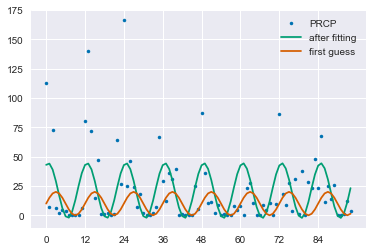

In [37]:
plt.plot(data, '.')
plt.plot(data_fit, label='after fitting')
plt.plot(data_first_guess, label='first guess')
plt.xticks(np.arange(0, df.index.max(), 12))
plt.legend();

#### Regression with Scipy

#### Example: Moons of the Solar System

In [38]:
df_moons = pd.read_excel('../data/moons.xlsx')
df_planets = pd.read_excel('../data/planets.xlsx')
df_solar = pd.merge(df_moons, df_planets, left_on='planet_name', right_on='planet_name')
df_solar['moon_volume_km3'] = 4/3*np.pi*(df_solar.moon_diameter_km/2)**3
df_solar['planet_volume_km3'] = 4/3*np.pi*(df_solar.planet_diameter_km/2)**3
df_solar

,moon_name,planet_name,moon_planet_distance_km,moon_diameter_km,planet_diameter_km,planet_sun_distance_km,planet_sun_distance_au,moon_volume_km3,planet_volume_km3
0,Moon,Earth,384000,3476,12742,1.495979e+08,1.000,2.199064e+10,1.083207e+12
1,Deimos,Mars,9270,20,6779,2.281368e+08,1.525,4.188790e+03,1.631156e+11
2,Phobos,Mars,23460,8,6779,2.281368e+08,1.525,2.680826e+02,1.631156e+11
3,Callisto,Jupiter,1883000,4800,139822,7.786569e+08,5.205,5.790584e+10,1.431282e+15
4,Europa,Jupiter,670900,3126,139822,7.786569e+08,5.205,1.599431e+10,1.431282e+15
5,Ganymede,Jupiter,1070000,5276,139822,7.786569e+08,5.205,7.689763e+10,1.431282e+15
6,Io,Jupiter,421600,3629,139822,7.786569e+08,5.205,2.502416e+10,1.431282e+15
7,Dione,Saturn,377400,1120,116464,1.427912e+09,9.545,7.356186e+08,8.271299e+14
8,Enceladus,Saturn,238020,498,116464,1.427912e+09,9.545,6.466759e+07,8.271299e+14
9,Hyperion,Saturn,1481000,226,116464,1.427912e+09,9.545,6.043993e+06,8.271299e+14


##### Pearson correlation

In [39]:
# pearson correlation (linear regression on values) of diameters
pearson_r_diameter, pearson_p_diameter = scipy.stats.pearsonr(df_solar.planet_diameter_km, df_solar.moon_diameter_km)
pearson_r_diameter, pearson_p_diameter

(0.39231409401451894, 0.064086346885027262)

In [40]:
# pearson correlation (linear regression on values) of volumes
pearson_r_volume, pearson_p_volume = scipy.stats.pearsonr(df_solar.planet_volume_km3, df_solar.moon_volume_km3)
pearson_r_volume, pearson_p_volume

(0.51865681539162767, 0.011223179377141783)

##### Spearman correlation

In [41]:
# spearman correlation (linear regression on ranks) of diameters
spearman_r_diameter, spearman_p_diameter = scipy.stats.spearmanr(df_solar.planet_diameter_km, df_solar.moon_diameter_km)
spearman_r_diameter, spearman_p_diameter

(0.45363079297812398, 0.029697361455537457)

In [42]:
# spearman correlation (linear regression on ranks) of volumes
spearman_r_volume, spearman_p_volume = scipy.stats.spearmanr(df_solar.planet_volume_km3, df_solar.moon_volume_km3)
spearman_r_volume, spearman_p_volume

(0.45363079297812398, 0.029697361455537457)

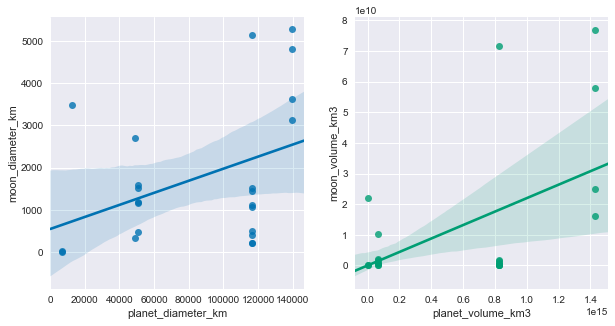

In [43]:
# plot linear regressions
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.regplot(x='planet_diameter_km', y='moon_diameter_km', data=df_solar, ax=ax[0])
sns.regplot(x='planet_volume_km3', y='moon_volume_km3', data=df_solar, ax=ax[1]);

What if we consider the *ratio* of moon size to planet size?

In [44]:
# calculate moon diameters and volumes relative to host planets
df_solar['moon_planet_relative_diameter'] = df_solar.moon_diameter_km/df_solar.planet_diameter_km
df_solar['moon_planet_relative_volume'] = df_solar.moon_volume_km3/df_solar.planet_volume_km3

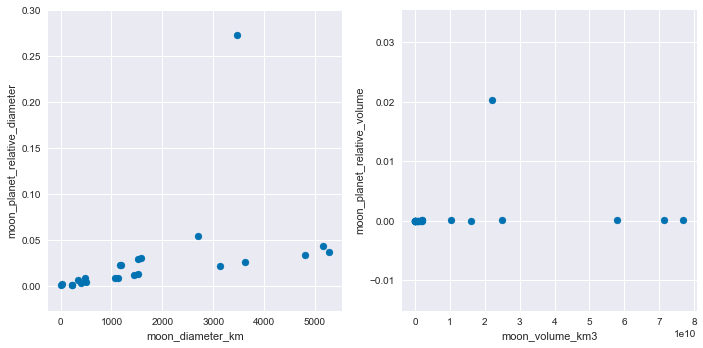

In [45]:
# plot scatter plots
fig, ax = plt.subplots(1, 2, figsize=(10,5))

ax[0].scatter(df_solar.moon_diameter_km, df_solar.moon_planet_relative_diameter)
ax[0].set_xlabel('moon_diameter_km')
ax[0].set_ylabel('moon_planet_relative_diameter')

ax[1].scatter(df_solar.moon_volume_km3, df_solar.moon_planet_relative_volume)
ax[1].set_xlabel('moon_volume_km3')
ax[1].set_ylabel('moon_planet_relative_volume')

fig.tight_layout()

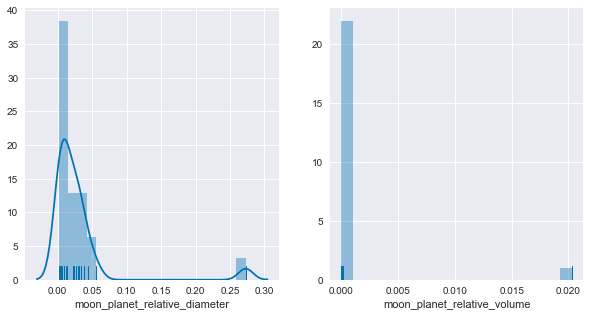

In [46]:
# plot distributions
fig, ax = plt.subplots(1, 2, figsize=(10,5))
sns.distplot(df_solar.moon_planet_relative_diameter, rug=True, bins=20, ax=ax[0])
sns.distplot(df_solar.moon_planet_relative_volume, kde=False, rug=True, bins=20, ax=ax[1]);
#ax[1].set_xscale('log')

#### Grubbs's test for outliers

Grubbs's test is used to detect outliers in a univariate data set assumed to come from a normally distributed population.

`outlier_utils` is a library for detecting and removing outliers using Grubbs's test.

In [47]:
# print outliers from the dataset - relative diameter
grubbs.max_test_outliers(df_solar.moon_planet_relative_diameter, alpha=0.05)

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.6/site-packages/outliers/smirnov_grubbs.py:185: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return data.argmax()


[0.27279861874117095]

In [48]:
# remove outliers - relative diameter
moon_planet_rel_diam_no_outliers = grubbs.test(df_solar.moon_planet_relative_diameter, alpha=0.05)
moon_planet_rel_diam_no_outliers

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.6/site-packages/outliers/smirnov_grubbs.py:153: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  index = relative_values.argmax()


1     0.002950
2     0.001180
3     0.034329
4     0.022357
5     0.037734
6     0.025954
7     0.009617
8     0.004276
9     0.001941
10    0.012330
11    0.003417
12    0.001889
13    0.013120
14    0.009102
15    0.044220
16    0.022869
17    0.009305
18    0.030084
19    0.031149
20    0.023460
21    0.006904
22    0.054931
Name: moon_planet_relative_diameter, dtype: float64

In [49]:
# print outliers from the dataset - relative volume (higher alpha)
grubbs.max_test_outliers(df_solar.moon_planet_relative_volume, alpha=0.000005)

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.6/site-packages/outliers/smirnov_grubbs.py:185: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  return data.argmax()


[0.02030142397437823]

In [50]:
# remove outliers - relative volume (higher alpha)
moon_planet_rel_vol_no_outliers = grubbs.test(df_solar.moon_planet_relative_volume, alpha=0.000005)
moon_planet_rel_vol_no_outliers

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.6/site-packages/outliers/smirnov_grubbs.py:153: FutureWarning: 'argmax' is deprecated. Use 'idxmax' instead. The behavior of 'argmax' will be corrected to return the positional maximum in the future. Use 'series.values.argmax' to get the position of the maximum now.
  index = relative_values.argmax()


1     2.567989e-08
2     1.643513e-09
3     4.045733e-05
4     1.117482e-05
5     5.372641e-05
6     1.748374e-05
7     8.893628e-07
8     7.818311e-08
9     7.307187e-09
10    1.874512e-06
11    3.990930e-08
12    6.740513e-09
13    2.258369e-06
14    7.539499e-07
15    8.646624e-05
16    1.196006e-05
17    8.057225e-07
18    2.722846e-05
19    3.022253e-05
20    1.291220e-05
21    3.291371e-07
22    1.657455e-04
Name: moon_planet_relative_volume, dtype: float64

### Tests of indpendence (of two nominal variables)

Test | Purpose | Notes | Example
----- | ----- | ----- | -----
Fisher's exact test | Test hypothesis that proportions are the same in different groups | Use for small sample sizes (less than 1000) | Count the number of live and dead patients after treatment with drug or placebo, test the hypothesis that the proportion of live and dead is the same in the two treatments, total sample <1000
Chi-square test of independence | Test fit of observed frequencies to expected frequencies | Use for large sample sizes (greater than 1000) | Count the number of live and dead patients after treatment with drug or placebo, test the hypothesis that the proportion of live and dead is the same in the two treatments, total sample >1000

#### Fisher's exact test

Use the Fisher's exact test of independence when you have two nominal variables and you want to see whether the proportions of one variable are different depending on the value of the other variable. Use it when the sample size is small.

Parameters
* table: array_like of ints.
    A 2x2 contingency table.  Elements should be non-negative integers.
* alternative: {'two-sided', 'less', 'greater'}, optional.
    Which alternative hypothesis to the null hypothesis the test uses.
    Default is 'two-sided'.

Returns
* oddsratio: float.
    This is prior odds ratio and not a posterior estimate.
* p_value: float.
    P-value, the probability of obtaining a distribution at least as
    extreme as the one that was actually observed, assuming that the
    null hypothesis is true.

Say we spend a few days counting whales and sharks in the Atlantic and
Indian oceans. In the Atlantic ocean we find 8 whales and 1 shark, in the
Indian ocean 2 whales and 5 sharks. Then our contingency table is:

In [51]:
f = pd.DataFrame([[8, 2],[1, 5]], 
                 index=['Atlantic', 'Indian'], 
                 columns=['whales', 'sharks'])
f

,whales,sharks
Atlantic,8,2
Indian,1,5


We use this table to find the p-value:

In [52]:
odds_ratio, p_value = scipy.stats.fisher_exact(f, alternative='two-sided')
odds_ratio, p_value

(20.0, 0.034965034965034947)

The probability that we would observe this or an even more imbalanced ratio
by chance is about 3.5%.  A commonly used significance level is 5%--if we
adopt that, we can therefore conclude that our observed imbalance is
statistically significant; whales prefer the Atlantic while sharks prefer
the Indian Ocean.

For tables with large numbers, the (inexact) chi-square test implemented
in the function `chi2_contingency` can also be used.

#### Chi-square test of independence

Use the chi-square test of independence when you have two nominal variables and you want to see whether the proportions of one variable are different for different values of the other variable. Use it when the sample size is large.

Parameters:
* observed: array_like.
    The contingency table. The table contains the observed frequencies
    (i.e. number of occurrences) in each category.  In the two-dimensional
    case, the table is often described as an "R x C table".

Returns:

* chi2: float.
    The test statistic.
* p: float.
    The p-value of the test
* dof: int.
    Degrees of freedom
* expected: ndarray, same shape as `observed`.
    The expected frequencies, based on the marginal sums of the table.

In [53]:
chi2, p, dof, expected = scipy.stats.chi2_contingency(f)
chi2, p, dof, expected

(3.8095238095238093, 0.050961936967763424, 1, array([[ 5.625,  4.375],
        [ 3.375,  2.625]]))

### Analysis of variance

#### One-sample *t*-test

The one-sample *t*-test is a two-sided test for the null hypothesis that the expected value
(mean) of a sample of independent observations `a` is equal to the given
population mean, `popmean`.

Parameters:
* a: array_like.
    Sample observation
* popmean: float or array_like.
    Expected value in null hypothesis, if array_like than it must have the
    same shape as `a` excluding the axis dimension
    
Returns:
* statistic: float or array.
    t-statistic
* pvalue: float or array.
    Two-tailed p-value

The population mean of moon-to-planet diameters (excluding our Moon) is approximately 0.018. Our moon is excluded from this population because its relative diameter of 0.273 is an outlier.

In [54]:
moon_planet_rel_diam_no_outliers.mean()

0.018323558187319684

We **cannot** reject the null hypothesis that an expected mean of 0.02 is equal to population mean.

In [55]:
scipy.stats.ttest_1samp(moon_planet_rel_diam_no_outliers, 0.02)

Ttest_1sampResult(statistic=-0.51001168507614936, pvalue=0.61536196351015127)

We **can** reject the null hypothesis that an expected mean equal to the Moon-Earth diamter ratio (0.273) is equal to population mean.

In [56]:
scipy.stats.ttest_1samp(moon_planet_rel_diam_no_outliers, 0.273)

Ttest_1sampResult(statistic=-77.478359377362779, pvalue=2.6973888513820512e-27)

#### Two-sample *t*-test

The two-sample *t* test is a two-sided test for the null hypothesis that two independent samples
have identical average (expected) values. This test assumes that the populations have identical variances by default.

Parameters
* a, b: array_like.
    The arrays must have the same shape, except in the dimension
    corresponding to `axis` (the first, by default).
* axis : int or None, optional
    Axis along which to compute test. If None, compute over the whole
    arrays, `a`, and `b`.
    
Returns
* statistic: float or array.
    The calculated t-statistic.
* pvalue: float or array.
    The two-tailed p-value.

In [57]:
# create sample data
np.random.seed(1)
a = np.random.randn(40)
b = 1.5*np.random.randn(50)+2

In [58]:
# scipy.stats.ttest_ind (t-test for the means of two independent samples)
t, p = scipy.stats.ttest_ind(a, b, equal_var=False)
print("ttest_ind: t = %g  p = %g" % (t, p))

ttest_ind: t = -9.86068  p = 7.14488e-16


In [59]:
# compute the descriptive statistics of a and b
abar = a.mean()
avar = a.var(ddof=1)
na = a.size
adof = na - 1

bbar = b.mean()
bvar = b.var(ddof=1)
nb = b.size
bdof = nb - 1

In [60]:
# scipy.stats.ttest_ind_from_stats (t-test for the means of two independent samples from descriptive stats)
t2, p2 = scipy.stats.ttest_ind_from_stats(abar, np.sqrt(avar), na,
                              bbar, np.sqrt(bvar), nb,
                              equal_var=False)
print("ttest_ind_from_stats: t = %g, p = %g" % (t2, p2))

ttest_ind_from_stats: t = -9.86068, p = 7.14488e-16


In [61]:
# use the formulas directly
tf = (abar - bbar) / np.sqrt(avar/na + bvar/nb)
dof = (avar/na + bvar/nb)**2 / (avar**2/(na**2*adof) + bvar**2/(nb**2*bdof))
pf = 2*scipy.special.stdtr(dof, -np.abs(tf))

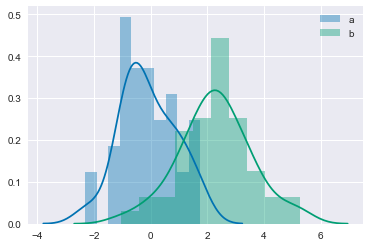

In [62]:
# plot the distributions
sns.distplot(a, bins=10, label='a')
sns.distplot(b, bins=10, label='b')
plt.legend();

#### One-way anova

The one-way ANOVA tests the null hypothesis that two or more groups have
the same population mean.  The test is applied to samples from two or
more groups, possibly with differing sizes.

Parameters
* sample1, sample2, ... : array_like.
    The sample measurements for each group.

Returns
* statistic: float.
    The computed F-value of the test.
* pvalue: float.
    The associated p-value from the F-distribution.

Note: The ANOVA test has important assumptions that must be satisfied in order
for the associated p-value to be valid.

1. The samples are independent.
2. Each sample is from a normally distributed population.
3. The population standard deviations of the groups are all equal.  This
   property is known as homoscedasticity.

If these assumptions are not true for a given set of data, it may still be
possible to use the Kruskal-Wallis H-test (`scipy.stats.kruskal`) although
with some loss of power.

Here are some data on a shell measurement (the length of the anterior
adductor muscle scar, standardized by dividing by length) in the mussel
*Mytilus trossulus* from five locations: Tillamook, Oregon; Newport, Oregon;
Petersburg, Alaska; Magadan, Russia; and Tvarminne, Finland, taken from a
much larger data set used in McDonald et al. (1991).

In [63]:
tillamook = [0.0571, 0.0813, 0.0831, 0.0976, 0.0817, 0.0859, 0.0735, 0.0659, 0.0923, 0.0836]
newport = [0.0873, 0.0662, 0.0672, 0.0819, 0.0749, 0.0649, 0.0835, 0.0725]
petersburg = [0.0974, 0.1352, 0.0817, 0.1016, 0.0968, 0.1064, 0.105]
magadan = [0.1033, 0.0915, 0.0781, 0.0685, 0.0677, 0.0697, 0.0764, 0.0689]
tvarminne = [0.0703, 0.1026, 0.0956, 0.0973, 0.1039, 0.1045]

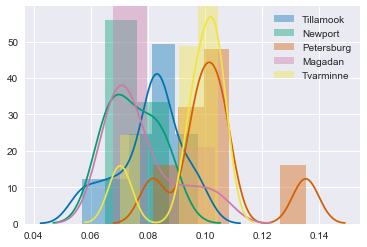

In [64]:
sns.distplot(tillamook, label='Tillamook')
sns.distplot(newport, label='Newport')
sns.distplot(petersburg, label='Petersburg')
sns.distplot(magadan, label='Magadan')
sns.distplot(tvarminne, label='Tvarminne')
plt.legend();

In [65]:
scipy.stats.f_oneway(tillamook, newport, petersburg, magadan, tvarminne)

F_onewayResult(statistic=7.1210194716424473, pvalue=0.00028122423145345439)

The means **were** significantly heterogeneous (one-way anova, $F_{4,34}=7.12, P=2.8\times10^{-4}$). 

Complete ANOVA results (see http://www.biostathandbook.com/onewayanova.html):

. | sum of squares | d.f. | mean square | Fs | P
-----|-----|-----|-----|-----
among groups | 0.00452| 4 | 0.001113 | 7.12 | 2.8e-4
within groups | 0.00539 | 34 | 0.000159 | | 
total | 0.00991 | 38 |  |  |

### Microbiome analysis

This last lesson is taken from the documentation for [Scikit-bio](http://scikit-bio.org/docs/latest/). The package `skbio.diversity` provides diversity measures for OTU tables.

In [66]:
from skbio.diversity import alpha_diversity
from skbio import TreeNode
from io import StringIO
from skbio.diversity import beta_diversity
from skbio.stats.distance import mantel
from skbio.stats.ordination import pcoa
from skbio.stats.distance import anosim

Create a matrix containing 6 samples (rows) and 7 OTUs (columns):

In [67]:
data = [[23, 64, 14, 0, 0, 3, 1],
        [0, 3, 35, 42, 0, 12, 1],
        [0, 5, 5, 0, 40, 40, 0],
        [44, 35, 9, 0, 1, 0, 0],
        [0, 2, 8, 0, 35, 45, 1],
        [0, 0, 25, 35, 0, 19, 0]]
ids = list('ABCDEF')

In [68]:
ids

['A', 'B', 'C', 'D', 'E', 'F']

#### Alpha-diversity

First, we’ll compute observed OTUs, an alpha diversity metric, for each sample using the alpha_diversity driver function:

In [69]:
adiv_obs_otus = alpha_diversity('observed_otus', data, ids)
adiv_obs_otus

A    5
B    5
C    4
D    4
E    5
F    3
dtype: int64

Next we’ll compute Faith’s PD on the same samples. Since this is a phylogenetic diversity metric, we’ll first create a tree and an ordered list of OTU identifiers.

In [70]:
tree = TreeNode.read(StringIO(
               '(((((OTU1:0.5,OTU2:0.5):0.5,OTU3:1.0):1.0):0.0,'
               '(OTU4:0.75,(OTU5:0.5,(OTU6:0.5,OTU7:0.5):0.5):'
               '0.5):1.25):0.0)root;'))
otu_ids = ['OTU1', 'OTU2', 'OTU3', 'OTU4', 'OTU5', 'OTU6', 'OTU7']
adiv_faith_pd = alpha_diversity('faith_pd', data, ids=ids, otu_ids=otu_ids, tree=tree)
adiv_faith_pd

A    6.75
B    7.00
C    6.25
D    5.75
E    6.75
F    5.50
dtype: float64

#### Beta-diversity

Now we’ll compute Bray-Curtis distances, a beta diversity metric, between all pairs of samples. Notice that the data and ids parameters provided to beta_diversity are the same as those provided to alpha_diversity.

In [71]:
bc_dm = beta_diversity("braycurtis", data, ids)
print(bc_dm)

6x6 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E', 'F'
Data:
[[ 0.          0.78787879  0.86666667  0.30927835  0.85714286  0.81521739]
 [ 0.78787879  0.          0.78142077  0.86813187  0.75        0.1627907 ]
 [ 0.86666667  0.78142077  0.          0.87709497  0.09392265  0.71597633]
 [ 0.30927835  0.86813187  0.87709497  0.          0.87777778  0.89285714]
 [ 0.85714286  0.75        0.09392265  0.87777778  0.          0.68235294]
 [ 0.81521739  0.1627907   0.71597633  0.89285714  0.68235294  0.        ]]


Next, we’ll compute weighted UniFrac distances between all pairs of samples. Because weighted UniFrac is a phylogenetic beta diversity metric, we’ll need to pass the skbio.TreeNode and list of OTU ids that we created above. Again, these are the same values that were provided to alpha_diversity.

In [72]:
wu_dm = beta_diversity("weighted_unifrac", data, ids, tree=tree, otu_ids=otu_ids)
print(wu_dm)

6x6 distance matrix
IDs:
'A', 'B', 'C', 'D', 'E', 'F'
Data:
[[ 0.          2.77549923  3.82857143  0.42512039  3.8547619   3.10937312]
 [ 2.77549923  0.          2.26433692  2.98435423  2.24270353  0.46774194]
 [ 3.82857143  2.26433692  0.          3.95224719  0.16025641  1.86111111]
 [ 0.42512039  2.98435423  3.95224719  0.          3.98796148  3.30870431]
 [ 3.8547619   2.24270353  0.16025641  3.98796148  0.          1.82967033]
 [ 3.10937312  0.46774194  1.86111111  3.30870431  1.82967033  0.        ]]


Next we’ll do some work with these beta diversity distance matrices. First, we’ll determine if the UniFrac and Bray-Curtis distance matrices are significantly correlated by computing the Mantel correlation between them. Then we’ll determine if the p-value is significant based on an alpha of 0.05.

In [73]:
r, p_value, n = mantel(wu_dm, bc_dm)
print(r)
alpha = 0.05
print(p_value < alpha)

0.922404392093
True


Next, we’ll perform principal coordinates analysis (PCoA) on our weighted UniFrac distance matrix.

In [74]:
wu_pc = pcoa(wu_dm)

/Users/luke.thompson/miniconda3/envs/python3/lib/python3.6/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:111: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.011492611219229593 and the largest is 16.021722090908206.
  RuntimeWarning


PCoA plots are only really interesting in the context of sample metadata, so let’s define some before we visualize these results.

In [75]:
sample_md = [
    ('A', ['gut', 's1']),
    ('B', ['skin', 's1']),
    ('C', ['tongue', 's1']),
    ('D', ['gut', 's2']),
    ('E', ['tongue', 's2']),
    ('F', ['skin', 's2'])]
sample_md = pd.DataFrame.from_items( sample_md, columns=['body_site', 'subject'], orient='index')
sample_md

,body_site,subject
A,gut,s1
B,skin,s1
C,tongue,s1
D,gut,s2
E,tongue,s2
F,skin,s2


Now let’s plot our PCoA results, coloring each sample by the subject it was taken from:

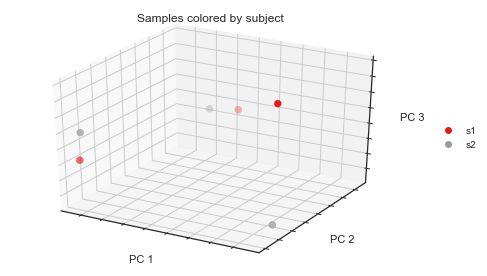

In [76]:
sns.set_style('white')
fig = wu_pc.plot(sample_md, 'subject',
    axis_labels=('PC 1', 'PC 2', 'PC 3'),
    title='Samples colored by subject', cmap='Set1', s=50)

We don’t see any clustering/grouping of samples. If we were to instead color the samples by the body site they were taken from, we see that the samples from the same body site (those that are colored the same) appear to be closer to one another in the 3-D space then they are to samples from other body sites.

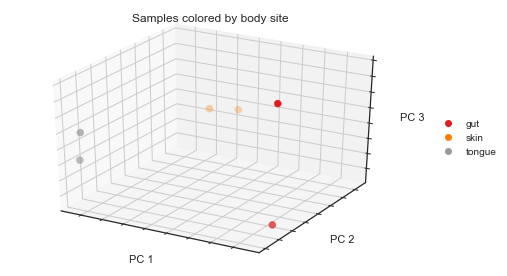

In [77]:
fig = wu_pc.plot(sample_md, 'body_site',
    axis_labels=('PC 1', 'PC 2', 'PC 3'),
    title='Samples colored by body site', cmap='Set1', s=50)

Ordination techniques, such as PCoA, are useful for exploratory analysis. The next step is to quantify the strength of the grouping/clustering that we see in ordination plots. There are many statistical methods available to accomplish this; many operate on distance matrices. Let’s use ANOSIM to quantify the strength of the clustering we see in the ordination plots above, using our weighted UniFrac distance matrix and sample metadata.

First test the grouping of samples by **subject**:

In [78]:
results = anosim(wu_dm, sample_md, column='subject', permutations=999)

In [79]:
results['test statistic']

-0.33333333333333331

In [80]:
results['p-value'] < 0.1

False

The negative value of ANOSIM’s R statistic indicates anti-clustering, but the p-value is insignificant at an alpha of 0.1.

Now let’s test the grouping of samples by **body site**:

In [81]:
results = anosim(wu_dm, sample_md, column='body_site', permutations=999)

In [82]:
results['test statistic']

1.0

In [83]:
results['p-value'] < 0.1

True

The R statistic indicates strong separation of samples based on body site. The p-value is significant at an alpha of 0.1.

#### Correlations with metadata

We can also explore the alpha diversity in the context of sample metadata. To do this, let’s add the Observed OTU and Faith PD data to our sample metadata. This is straight-forward beause alpha_diversity returns a Pandas Series object, and we’re representing our sample metadata in a Pandas DataFrame object.

In [84]:
sample_md['Observed OTUs'] = adiv_obs_otus
sample_md['Faith PD'] = adiv_faith_pd
sample_md

,body_site,subject,Observed OTUs,Faith PD
A,gut,s1,5,6.75
B,skin,s1,5,7.00
C,tongue,s1,4,6.25
D,gut,s2,4,5.75
E,tongue,s2,5,6.75
F,skin,s2,3,5.50


We can investigate these alpha diversity data in the context of our metadata categories. For example, we can generate boxplots showing Faith PD by body site.

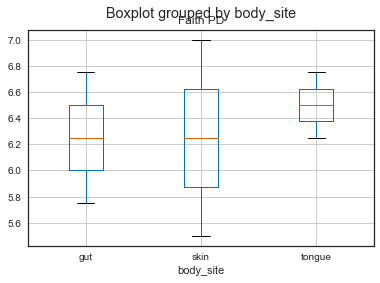

In [85]:
fig = sample_md.boxplot(column='Faith PD', by='body_site')

We can also compute Spearman correlations between all pairs of columns in this DataFrame. Since our alpha diversity metrics are the only two numeric columns (and thus the only columns for which Spearman correlation is relevant), this will give us a symmetric 2x2 correlation matrix.

In [86]:
sample_md.corr(method="spearman")

,Observed OTUs,Faith PD
Observed OTUs,1.000000,0.939336
Faith PD,0.939336,1.000000


### R kernel in Jupyter notebooks

Finally, if you want to use R in Jupyter notebooks, installation and instructions are here: <https://www.continuum.io/blog/developer/jupyter-and-conda-r>